In [39]:
import numpy as np
import statistics as ST
import pandas as pd
import scipy.stats
import random
import copy
import time
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib import colors
from matplotlib import gridspec
import json
from matplotlib import cm
plt.rcParams["font.family"] = "Arial"
plt.rcParams['pdf.fonttype'] = 42

In [2]:
t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print(current_time)

14:44:25


## **1 Preparation**

### **1.1 Input**

In [3]:
#This is the absolute path
Path_ab1="C:/Users/lumia/Dropbox (University of Michigan)/1. Haiqing Xu/1. Project/Frameshifting/Final_analysis/"
Path_ab2="C:/Users/lumia/Dropbox (University of Michigan)/1. Haiqing Xu/1. Project/10. Genetic code against nutrient limitation/"
#This is the aminoacid properties
aa1=Path_ab1+'/Input/Final_metrics.csv'
aa2=Path_ab2+'/Amino_acid_properites/Nutrient_metrics.csv'
Path_ab3="F:/Science_critical_comment_data/"

In [4]:
#nutrient data
Nutrient_data=pd.read_csv(aa2)
Nutrient_data.set_index('Amino acid',inplace=True)
#MT= pd.read_csv(aa1) 
#MT.set_index('Amino acid',inplace=True)
p_name_list=list(Nutrient_data.columns)
#random genetic code
simulated_lib=Path_ab2+"/Random_genetic_code/New_RGC_1e4"
#codon frequency data
codon_freq_address=Path_ab2+'/Codon_frequency_table/ModelOrganisms.csv'

In [5]:
#read the codon frequency information into a pandas dataframe
codon_freq=pd.read_csv(codon_freq_address)
#Drop unnecessary columns
codon_freq=codon_freq.drop(columns=['Unnamed: 0','Assembly','Translation Table','Organelle','Division'])

In [6]:
#this list contains the codon names
codon_freq_name_list=codon_freq.columns[8:]

In [42]:
#this is the address for pvalue
pvalue_dic_address_1=Path_ab3+'1e6_Figure4_NC/pvalue_dictionary.json'
pvalue_dic_address_2=Path_ab3+'1e6_Figure4_My_simulation_NC/pvalue_dictionary.json'
pvalue_dic_address_3=Path_ab3+'1e6_Figure4_My_simulation/pvalue_dictionary.json'
pvalue_dic_address_4=Path_ab3+'1e6_Figure4_NC_no_stop/pvalue_dictionary.json'

### **1.2 Functions**

In [8]:
def read_benchmark(input_address):
    temp_list=[]
    with open(input_address,'r') as handler:
        handler.readline()
        temp=handler.readline().strip().split(',')
        temp_list=[float(x) for x in temp]
    return(temp_list)

In [9]:
def extract_one_measurement(Group_name,total_dic,number):
#The group_name is the name of group that I want to extract, number indicate which property I want to look at.
#To be noted,
    temp_dic=total_dic[Group_name]
    total_matrix=[]
    for key,value in temp_dic.items():
        temp_list=[]
        for sub_value in value:
            temp_list.append(sub_value[number])
        total_matrix.append(temp_list)
    return(np.array(total_matrix))

In [10]:
def unpacking(input_dict):
    temp_df=[]
    for value in input_dict.values():
        for sub_value in value.values():
            temp_df.append(np.mean(np.array(sub_value)[1:,], axis=0))
    return(temp_df)

In [11]:
def find_sig_species(input_dict,cutoff):
    #this function take the pvalue dictionary as input and generate a list of label for all the species
    #cutoff is the number of pvalue across all the Ts/Tv value to be used to determine if a species' UGC is significant or not
    temp_list=[]
    for value in input_dict.values():
        for sub_value in value.values():
            temp_label=[]
            for x in np.transpose(sub_value[1:]): #be careful to skip the first one, it is the LD hurst version
                temp_sum=sum(np.array(x)<0.05)
                if temp_sum>=cutoff:
                    temp_label.append("sig")
                else:
                    temp_label.append("none_sig")
            temp_list.append(temp_label)
    return(temp_list)

### **1.3 UGC structure**

In [12]:
#make a dictionary, the codon is the key, while the aa is the value
UGC_table = { 
'TTT':'F', 'TTC':'F', 'TTA':'L', 'TTG':'L', 
'TCT':'S', 'TCC':'S', 'TCA':'S', 'TCG':'S', 
'TAT':'Y', 'TAC':'Y', 'TAA':'_', 'TAG':'_', 
'TGT':'C', 'TGC':'C', 'TGA':'_', 'TGG':'W', 
'CTT':'L', 'CTC':'L', 'CTA':'L', 'CTG':'L', 
'CCT':'P', 'CCC':'P', 'CCA':'P', 'CCG':'P', 
'CAT':'H', 'CAC':'H', 'CAA':'Q', 'CAG':'Q', 
'CGT':'R', 'CGC':'R', 'CGA':'R', 'CGG':'R',     
'ATT':'I', 'ATC':'I', 'ATA':'I', 'ATG':'M', 
'ACT':'T', 'ACC':'T', 'ACA':'T', 'ACG':'T', 
'AAT':'N', 'AAC':'N', 'AAA':'K', 'AAG':'K', 
'AGT':'S', 'AGC':'S', 'AGA':'R', 'AGG':'R',                  
'GTT':'V', 'GTC':'V', 'GTA':'V', 'GTG':'V',  
'GCT':'A', 'GCC':'A', 'GCA':'A', 'GCG':'A',
'GAT':'D', 'GAC':'D', 'GAA':'E', 'GAG':'E', 
'GGT':'G', 'GGC':'G', 'GGA':'G', 'GGG':'G', 
       
    } 

In [13]:
#Here I create a dictionary where the keys is the 4 element square block name. 
#The name is the order number from left to right. And from top to bottom.
UGC_block_information={
    '0':['F','F','L','L'],'1':['S','S','S','S'],'2':['Y','Y','_','_'],'3':['C','C','_','W'],'4':['L','L','L','L'],
    '5':['P','P','P','P'],'6':['H','H','Q','Q'],'7':['R','R','R','R'],'8':['I','I','I','M'],'9':['T','T','T','T'],
    '10':['N','N','K','K'],'11':['S','S','R','R'],'12':['V','V','V','V'],'13':['A','A','A','A'],'14':['D','D','E','E'],
    '15':['G','G','G','G'],
}

In [14]:
#make a dictionary, the block name as the key, a list of condon correponding to this block is the value
UGC_block={}
for key,value in UGC_table.items():
    if value in UGC_block.keys():
        UGC_block[value].append(key)
    else:
        UGC_block[value]=[key]

### **1.3 Seperate species accoridng to kingdom**

In [15]:
Bacteria_group=[2097,1423,562,354,100226]
Extremophiles_group=[41673,272844,1917166,694429,3046,797304,243230]
Unicelluar_Eukaryotes_group=[4896,4932,35128,162425,2903,3055]
Plants_group=[3702,34305,3694,3218,4530,4577]
Animals_group=[6239,8364,7070,7955,9031,9598,10181,10090,10116,8296,9615,9606,7227,9685,59729]

In [16]:
Total_frequency_table=[Bacteria_group,Extremophiles_group,Unicelluar_Eukaryotes_group,Plants_group,Animals_group]
Group_name_list=['Bacteria','Extremophiles','Unicelluar_Eukaryotes','Plants','Animals']

## **2 Calculation**

### **2.1 pvalue of UGC**

In [17]:
#ratio list for Ts/Tv bias
ratio_list=[0.2,1/4,1/3,0.5,1,2,3,4,5]
#I create a list to store dictionarys for Ts/Tv metrics
TsTv_list=[]
TsTv_list.append({1:2,2:5,3:1})
Position_list=[]
Position_list.append({1:0.5,2:0.1,3:1})
for x in range(1,10):
    temp_dict={1:ratio_list[x-1],2:ratio_list[x-1],3:ratio_list[x-1]}
    TsTv_list.append(temp_dict)
    Position_list.append({1:1,2:1,3:1})

In [18]:
with open(pvalue_dic_address_1) as f:
    tt=json.load(f)
Total_pvalue_dic_NC= json.loads(tt)

In [19]:
with open(pvalue_dic_address_2) as f:
    tt=json.load(f)
Total_pvalue_dic_MS_NC= json.loads(tt)

In [20]:
with open(pvalue_dic_address_3) as f:
    tt=json.load(f)
Total_pvalue_dic_MS= json.loads(tt)

In [43]:
with open(pvalue_dic_address_4) as f:
    tt=json.load(f)
Total_pvalue_dic_NC_NS= json.loads(tt)

In [21]:
#Here I convert the property dataframe into a dic, the key is the shortname for AA, and values are corresponding property value
property_dic={}
for index, row in Nutrient_data.iterrows():
    property_dic[index]=[x for x in row] #The aa short name is a key and the propery is the value
#adding the option of stop codon.
property_dic['_']=[0,0,0]

### **1.2 Figure**

#### **1.2.1 Figure Q3**

In [22]:
sig_label=find_sig_species(Total_pvalue_dic_NC,5)

In [23]:
new_path=Path_ab2+'Figure'

In [25]:
#### **1.2.1 Figure 1** Ts/Tv rate pick kapa=3

In [46]:
Nutrient_list

[2, 0, 3]

In [45]:
Group_name_list

['Bacteria', 'Extremophiles', 'Unicelluar_Eukaryotes', 'Plants', 'Animals']

In [54]:
Nutrient_list

[2, 0, 3]

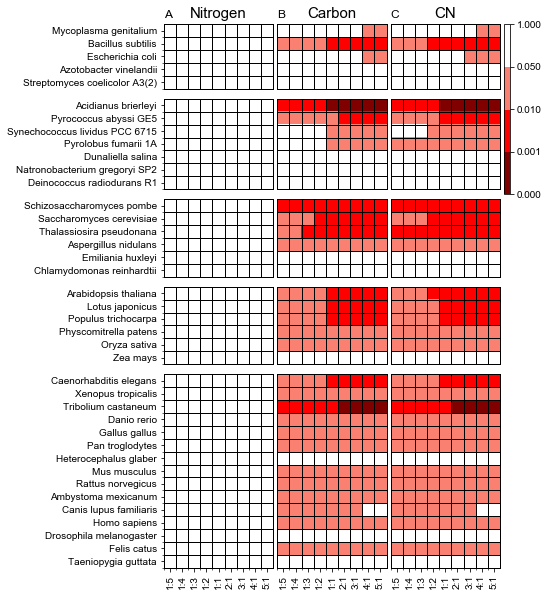

In [40]:
# new_path=Path_ab2+'Figure'
pname=new_path+'/Figure_S3.pdf'

Nutrient_list=[2,0,3]
Nutrient_name_list=['Nitrogen','Carbon','CN']


#y axis label
x_label=['1:5','1:4','1:3','1:2','1:1','2:1','3:1','4:1','5:1']
#the width ratio of subplot
#I exclude bacteria
height_ratios=[len(Total_pvalue_dic_MS_NC[x].keys()) for x in Group_name_list]
fig1,axes = plt.subplots(5, 4, gridspec_kw={'height_ratios': height_ratios,'width_ratios':[20,20,20,1] },figsize=(8,10),sharey='row')

np.transpose(axes)[0,]

#The following part is for specifying the color and scale
cmap = colors.ListedColormap(['maroon','red','salmon','white'])
bounds=[1e-7, 1e-3, 1e-2, 0.05,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

#this is for nitrogen
for a,b,c in zip(range(3),Nutrient_list,Nutrient_name_list):
    count=0
    for x,y in zip(np.transpose(axes)[a,:6],Group_name_list):

        temp_data=extract_one_measurement(y,Total_pvalue_dic_NC,b)[:,1:]
        im=x.imshow(temp_data,cmap=cmap, norm=norm,aspect='auto')
        if a!=0:
            plt.setp(x.get_yticklabels(), visible=False)
            x.yaxis.set_ticks_position('none') 
        count+=1

        #set x/y major tick
        x.set_xticks(np.arange(len(x_label)))
        x.set_yticks(np.arange(len(Total_pvalue_dic_MS_NC[y].keys())))

        #set x/y minor tick
        x.set_yticks(np.arange(len(Total_pvalue_dic_MS_NC[y].keys()))+0.5, minor=True)
        x.set_xticks(np.arange(len(x_label))-0.5,minor=True)
        x.grid(which='minor', color='black', linestyle='-', linewidth=1)

        #here I specify the border line width
        for axis in ['top','bottom','left','right']:
            x.spines[axis].set_linewidth(1)
        
        x.set_xticklabels(x_label,rotation='vertical')
        x.set_yticklabels(Total_pvalue_dic_MS_NC[y].keys())
        if count!=5:
            plt.setp(x.get_xticklabels(), visible=False)
            x.xaxis.set_ticks_position('none') 


plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.1)

axes[0,0].set_title('Nitrogen',loc='center',fontsize=15)
axes[0,0].set_title('A',loc='left')

axes[0,1].set_title('Carbon',loc='center',fontsize=15)
axes[0,1].set_title('B',loc='left')

axes[0,2].set_title('CN',loc='center',fontsize=15)
axes[0,2].set_title('C',loc='left')
#I remove unwanted axis
for x in np.transpose(axes)[3,]:
    x.axis('off')


ax1=fig1.add_subplot(3,61,61)  
plt.colorbar(im,cax=ax1)



plt.gcf().subplots_adjust(left=0.30)
plt.rcParams['pdf.fonttype'] = 42
plt.savefig(pname)

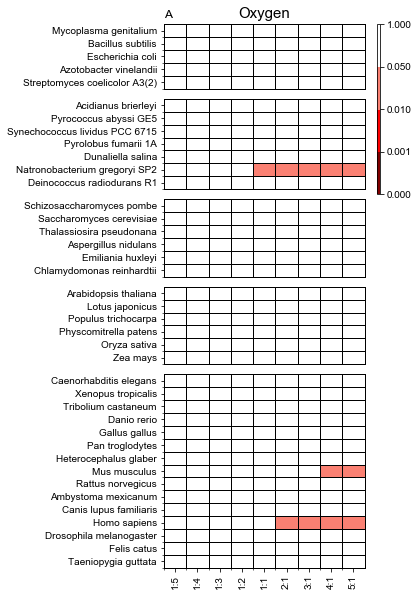

In [84]:
# new_path=Path_ab2+'Figure'
pname=new_path+'/Figure_S4.pdf'

Nutrient_list=[2,0,3]
Nutrient_name_list=['Nitrogen','Carbon','CN']


#y axis label
x_label=['1:5','1:4','1:3','1:2','1:1','2:1','3:1','4:1','5:1']
#the width ratio of subplot
#I exclude bacteria
height_ratios=[len(Total_pvalue_dic_MS_NC[x].keys()) for x in Group_name_list]
fig1,axes = plt.subplots(5, 2, gridspec_kw={'height_ratios': height_ratios,'width_ratios':[20,1] },figsize=(5,10),sharey='row')

np.transpose(axes)[0,]

#The following part is for specifying the color and scale
cmap = colors.ListedColormap(['maroon','red','salmon','white'])
bounds=[1e-7, 1e-3, 1e-2, 0.05,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

#this is for nitrogen

count=0
for x,y in zip(np.transpose(axes)[0,:6],Group_name_list):

    temp_data=extract_one_measurement(y,Total_pvalue_dic_NC_NS,1)[:,1:]
    im=x.imshow(temp_data,cmap=cmap, norm=norm,aspect='auto')
    count+=1

    #set x/y major tick
    x.set_xticks(np.arange(len(x_label)))
    x.set_yticks(np.arange(len(Total_pvalue_dic_MS_NC[y].keys())))

    #set x/y minor tick
    x.set_yticks(np.arange(len(Total_pvalue_dic_MS_NC[y].keys()))+0.5, minor=True)
    x.set_xticks(np.arange(len(x_label))-0.5,minor=True)
    x.grid(which='minor', color='black', linestyle='-', linewidth=1)

    #here I specify the border line width
    for axis in ['top','bottom','left','right']:
        x.spines[axis].set_linewidth(1)

    x.set_xticklabels(x_label,rotation='vertical')
    x.set_yticklabels(Total_pvalue_dic_MS_NC[y].keys())
    if count!=5:
        plt.setp(x.get_xticklabels(), visible=False)
        x.xaxis.set_ticks_position('none') 


plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.1)

axes[0,0].set_title('Oxygen',loc='center',fontsize=15)
axes[0,0].set_title('A',loc='left')

#I remove unwanted axis
for x in np.transpose(axes)[1,]:
    x.axis('off')


ax1=fig1.add_subplot(3,61,61)  
plt.colorbar(im,cax=ax1)



plt.gcf().subplots_adjust(left=0.30)
plt.rcParams['pdf.fonttype'] = 42
plt.savefig(pname)

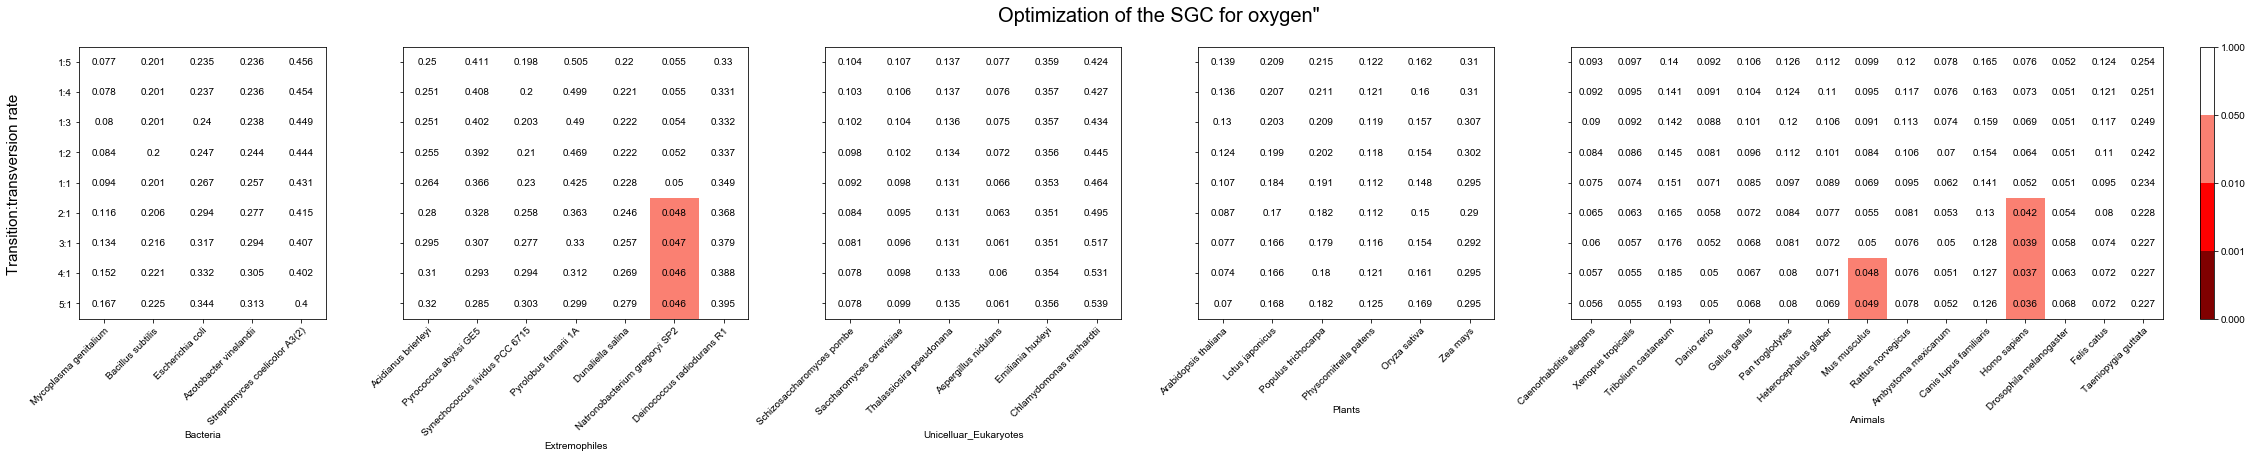

In [73]:
# new_path=Path_ab2+'Figure'
pname=new_path+'/Figure_S4.pdf'

#y axis label
y_label=['1:5','1:4','1:3','1:2','1:1','2:1','3:1','4:1','5:1']
#the width ratio of subplot
width_ratio=[len(Total_pvalue_dic_NC_NS[x].keys()) for x in Group_name_list]
fig1,axes = plt.subplots(1, 5, gridspec_kw={'width_ratios': width_ratio},figsize=(40,5),sharey=True)

cmap = colors.ListedColormap(['maroon','red','salmon','white'])
bounds=[1e-7, 1e-3, 1e-2, 0.05,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

for x,y in zip(axes,Group_name_list):
    
    temp_data=np.round(np.transpose(extract_one_measurement(y,Total_pvalue_dic_NC_NS,1)[:,1:]),3)
    im=x.imshow(temp_data,cmap=cmap, norm=norm,aspect='auto')
    x.set_yticks(np.arange(len(y_label)))
    x.set_xticks(np.arange(len(Total_pvalue_dic_NC_NS[y].keys())))
    x.set_yticklabels(y_label)
    x.set_xticklabels(Total_pvalue_dic_NC_NS[y].keys())
    for i in range(len(y_label)):
        for j in range(len(Total_pvalue_dic_NC_NS[y].keys())):
            text = x.text(j, i,temp_data[i, j],
                           ha="center", va="center", color="black")
    x.set_xlabel(y)
    plt.setp(x.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.colorbar(im)

fig1.text(0.1, 0.5, 'Transition:transversion rate', va='center', rotation='vertical',fontsize=15)
fig1.text(0.5, 0.95, 'Optimization of the SGC for oxygen"', ha='center',fontsize=20)

# plt.savefig(pname)

In [51]:
dict_list = [Total_pvalue_dic_NC,Total_pvalue_dic_NC_NS,Total_pvalue_dic_MS_NC]

#### **1.2.1 Figure 2**

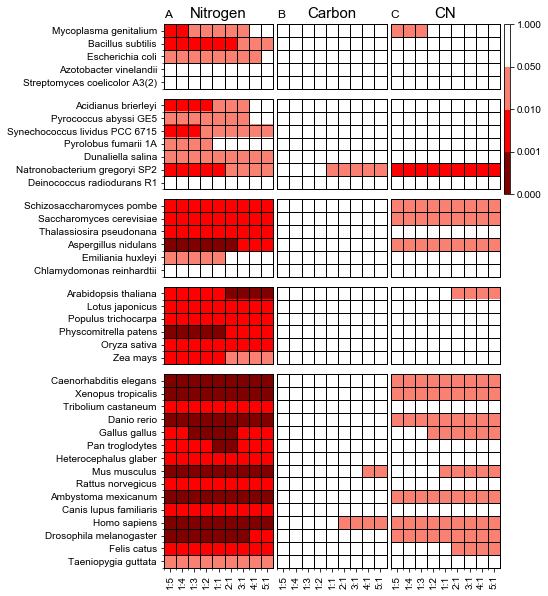

In [53]:
# new_path=Path_ab2+'Figure'
pname=new_path+'/Revision_Q2.pdf'

Nutrient_list=[2,0,3]
Nutrient_name_list=['Nitrogen','Carbon','CN']


#y axis label
x_label=['1:5','1:4','1:3','1:2','1:1','2:1','3:1','4:1','5:1']
#the width ratio of subplot
#I exclude bacteria
height_ratios=[len(Total_pvalue_dic_MS_NC[x].keys()) for x in Group_name_list]
fig1,axes = plt.subplots(5, 4, gridspec_kw={'height_ratios': height_ratios,'width_ratios':[20,20,20,1] },figsize=(8,10),sharey='row')

np.transpose(axes)[0,]

#The following part is for specifying the color and scale
cmap = colors.ListedColormap(['maroon','red','salmon','white'])
bounds=[1e-7, 1e-3, 1e-2, 0.05,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

#this is for nitrogen
for a,b in zip(range(3),dict_list):
    count=0
    for x,y in zip(np.transpose(axes)[a,:6],Group_name_list):

        temp_data=extract_one_measurement(y,b,1)[:,1:]
        im=x.imshow(temp_data,cmap=cmap, norm=norm,aspect='auto')
        if a!=0:
            plt.setp(x.get_yticklabels(), visible=False)
            x.yaxis.set_ticks_position('none') 
        count+=1

        #set x/y major tick
        x.set_xticks(np.arange(len(x_label)))
        x.set_yticks(np.arange(len(Total_pvalue_dic_MS_NC[y].keys())))

        #set x/y minor tick
        x.set_yticks(np.arange(len(Total_pvalue_dic_MS_NC[y].keys()))+0.5, minor=True)
        x.set_xticks(np.arange(len(x_label))-0.5,minor=True)
        x.grid(which='minor', color='black', linestyle='-', linewidth=1)

        #here I specify the border line width
        for axis in ['top','bottom','left','right']:
            x.spines[axis].set_linewidth(1)
        
        x.set_xticklabels(x_label,rotation='vertical')
        x.set_yticklabels(Total_pvalue_dic_MS_NC[y].keys())
        if count!=5:
            plt.setp(x.get_xticklabels(), visible=False)
            x.xaxis.set_ticks_position('none') 


plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.1)

axes[0,0].set_title('Nitrogen',loc='center',fontsize=15)
axes[0,0].set_title('A',loc='left')

axes[0,1].set_title('Carbon',loc='center',fontsize=15)
axes[0,1].set_title('B',loc='left')

axes[0,2].set_title('CN',loc='center',fontsize=15)
axes[0,2].set_title('C',loc='left')
#I remove unwanted axis
for x in np.transpose(axes)[3,]:
    x.axis('off')


ax1=fig1.add_subplot(3,61,61)  
plt.colorbar(im,cax=ax1)



plt.gcf().subplots_adjust(left=0.30)
plt.rcParams['pdf.fonttype'] = 42
# plt.savefig(pname)

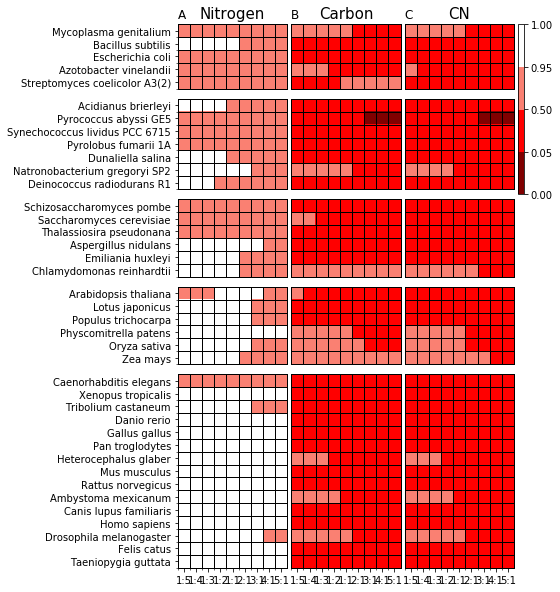

In [53]:
# new_path=Path_ab2+'Figure'
pname=new_path+'/Figure2.pdf'

Nutrient_list=[2,0,3]
Nutrient_name_list=['Nitrogen','Carbon','CN']


#y axis label
x_label=['1:5','1:4','1:3','1:2','1:1','2:1','3:1','4:1','5:1']
#the width ratio of subplot
#I exclude bacteria
height_ratios=[len(Total_pvalue_dic_MS_NC[x].keys()) for x in Group_name_list]
fig1,axes = plt.subplots(5, 4, gridspec_kw={'height_ratios': height_ratios,'width_ratios':[20,20,20,1] },figsize=(8,10),sharey='row')

np.transpose(axes)[0,]

#The following part is for specifying the color and scale
cmap = colors.ListedColormap(['maroon','red','salmon','white'])
bounds=[1e-7,0.05,0.5,0.95,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

#this is for nitrogen
for a,b,c in zip(range(3),Nutrient_list,Nutrient_name_list):
    count=0
    for x,y in zip(np.transpose(axes)[a,:6],Group_name_list):

        temp_data=extract_one_measurement(y,Total_pvalue_dic_MS_NC,b)[:,1:]
        im=x.imshow(temp_data,cmap=cmap, norm=norm,aspect='auto')
        if a!=0:
            plt.setp(x.get_yticklabels(), visible=False)
            x.yaxis.set_ticks_position('none') 
        count+=1

        #set x/y major tick
        x.set_xticks(np.arange(len(x_label)))
        x.set_yticks(np.arange(len(Total_pvalue_dic_MS_NC[y].keys())))

        #set x/y minor tick
        x.set_yticks(np.arange(len(Total_pvalue_dic_MS_NC[y].keys()))+0.5, minor=True)
        x.set_xticks(np.arange(len(x_label))-0.5,minor=True)
        x.grid(which='minor', color='black', linestyle='-', linewidth=1)

        #here I specify the border line width
        for axis in ['top','bottom','left','right']:
            x.spines[axis].set_linewidth(1)
        
        x.set_xticklabels(x_label)
        x.set_yticklabels(Total_pvalue_dic_MS_NC[y].keys())
        if count!=5:
            plt.setp(x.get_xticklabels(), visible=False)
            x.xaxis.set_ticks_position('none') 


plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.1)

axes[0,0].set_title('Nitrogen',loc='center',fontsize=15)
axes[0,0].set_title('A',loc='left')

axes[0,1].set_title('Carbon',loc='center',fontsize=15)
axes[0,1].set_title('B',loc='left')

axes[0,2].set_title('CN',loc='center',fontsize=15)
axes[0,2].set_title('C',loc='left')
#I remove unwanted axis
for x in np.transpose(axes)[3,]:
    x.axis('off')


ax1=fig1.add_subplot(3,61,61)  
plt.colorbar(im,cax=ax1)



plt.gcf().subplots_adjust(left=0.30)
plt.rcParams['pdf.fonttype'] = 42
# plt.savefig(pname)

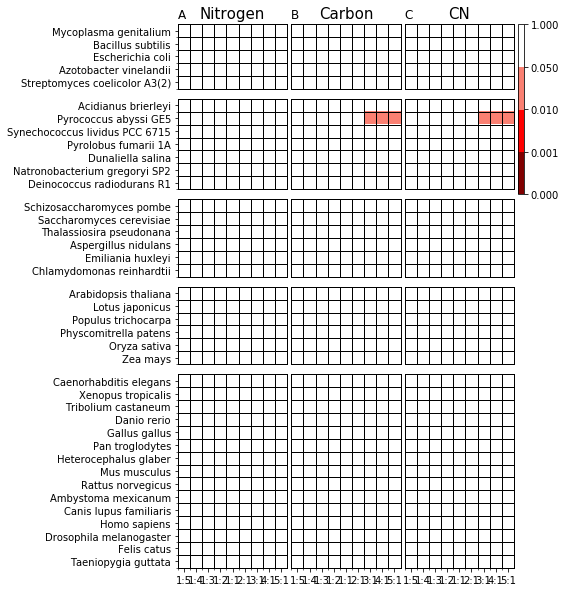

In [247]:
# new_path=Path_ab2+'Figure'
pname=new_path+'/Figure2.pdf'

Nutrient_list=[2,0,3]
Nutrient_name_list=['Nitrogen','Carbon','CN']


#y axis label
x_label=['1:5','1:4','1:3','1:2','1:1','2:1','3:1','4:1','5:1']
#the width ratio of subplot
#I exclude bacteria
height_ratios=[len(Total_pvalue_dic_MS_NC[x].keys()) for x in Group_name_list]
fig1,axes = plt.subplots(5, 4, gridspec_kw={'height_ratios': height_ratios,'width_ratios':[20,20,20,1] },figsize=(8,10),sharey='row')

np.transpose(axes)[0,]

#The following part is for specifying the color and scale
cmap = colors.ListedColormap(['maroon','red','salmon','white'])
bounds=[1e-7, 1e-3, 1e-2, 0.05,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

#this is for nitrogen
for a,b,c in zip(range(3),Nutrient_list,Nutrient_name_list):
    count=0
    for x,y in zip(np.transpose(axes)[a,:6],Group_name_list):

        temp_data=extract_one_measurement(y,Total_pvalue_dic_MS_NC,b)[:,1:]
        im=x.imshow(temp_data,cmap=cmap, norm=norm,aspect='auto')
        if a!=0:
            plt.setp(x.get_yticklabels(), visible=False)
            x.yaxis.set_ticks_position('none') 
        count+=1

        #set x/y major tick
        x.set_xticks(np.arange(len(x_label)))
        x.set_yticks(np.arange(len(Total_pvalue_dic_MS_NC[y].keys())))

        #set x/y minor tick
        x.set_yticks(np.arange(len(Total_pvalue_dic_MS_NC[y].keys()))+0.5, minor=True)
        x.set_xticks(np.arange(len(x_label))-0.5,minor=True)
        x.grid(which='minor', color='black', linestyle='-', linewidth=1)

        #here I specify the border line width
        for axis in ['top','bottom','left','right']:
            x.spines[axis].set_linewidth(1)
        
        x.set_xticklabels(x_label)
        x.set_yticklabels(Total_pvalue_dic_MS_NC[y].keys())
        if count!=5:
            plt.setp(x.get_xticklabels(), visible=False)
            x.xaxis.set_ticks_position('none') 


plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.1)

axes[0,0].set_title('Nitrogen',loc='center',fontsize=15)
axes[0,0].set_title('A',loc='left')

axes[0,1].set_title('Carbon',loc='center',fontsize=15)
axes[0,1].set_title('B',loc='left')

axes[0,2].set_title('CN',loc='center',fontsize=15)
axes[0,2].set_title('C',loc='left')
#I remove unwanted axis
for x in np.transpose(axes)[3,]:
    x.axis('off')


ax1=fig1.add_subplot(3,61,61)  
plt.colorbar(im,cax=ax1)



plt.gcf().subplots_adjust(left=0.30)
plt.rcParams['pdf.fonttype'] = 42
# plt.savefig(pname)

Nutrient_list=[2,0,3]
Nutrient_name_list=['Nitrogen','Carbon','CN']

#y axis label
x_label=['1:5','1:4','1:3','1:2','1:1','2:1','3:1','4:1','5:1']
#the width ratio of subplot
#I exclude bacteria
height_ratios=[len(Total_pvalue_dic_NC[x].keys()) for x in G_name]
height_ratios.append(0.25*sum(height_ratios))
fig1,axes = plt.subplots(7, 4, gridspec_kw={'height_ratios': height_ratios,'width_ratios':[20,20,20,1] },figsize=(10,15),sharey='row')

np.transpose(axes)[0,]

#The following part is for specifying the color and scale
cmap = colors.ListedColormap(['maroon','red','salmon','white'])
bounds=[1e-7, 1e-3, 1e-2, 0.05,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

#this is for nitrogen
for a,b,c in zip(range(3),Nutrient_list,Nutrient_name_list):
    count=0
    for x,y in zip(np.transpose(axes)[a,:6],G_name):

        temp_data=extract_one_measurement(y,Total_pvalue_dic_NC,b)[:,1:]
        im=x.imshow(temp_data,cmap=cmap, norm=norm,aspect='auto')
        if a!=0:
            plt.setp(x.get_yticklabels(), visible=False)
            x.yaxis.set_ticks_position('none') 
        count+=1
        if count==1:
            for j in range(len(x_label)):
                text = x.text(j, 0,"N/A", rotation=0,
                               ha="center", va="center", color="black",fontsize=8) 
        #set x/y major tick
        x.set_xticks(np.arange(len(x_label)))
        x.set_yticks(np.arange(len(Total_pvalue_dic[y].keys())))

        #set x/y minor tick
        x.set_yticks(np.arange(len(Total_pvalue_dic_NC[y].keys()))+0.5, minor=True)
        x.set_xticks(np.arange(len(x_label))-0.5,minor=True)
        x.grid(which='minor', color='black', linestyle='-', linewidth=1)

        #here I specify the border line width
        for axis in ['top','bottom','left','right']:
            x.spines[axis].set_linewidth(1)
        
        x.set_xticklabels(x_label)
        x.set_yticklabels(Total_pvalue_dic_NC[y].keys())
        if count!=6:
            plt.setp(x.get_xticklabels(), visible=False)
            x.xaxis.set_ticks_position('none') 


plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.1)

axes[0,0].set_title('Nitrogen',loc='center',fontsize=15)
axes[0,0].set_title('A',loc='left')

axes[0,1].set_title('Carbon',loc='center',fontsize=15)
axes[0,1].set_title('B',loc='left')

axes[0,2].set_title('CN',loc='center',fontsize=15)
axes[0,2].set_title('C',loc='left')
#I remove unwanted axis
for x in np.transpose(axes)[3,]:
    x.axis('off')
    
for x in axes[6,]:
    x.axis('off')

ax1=fig1.add_subplot(3,61,61)  
plt.colorbar(im,cax=ax1)


gs = gridspec.GridSpec(6,61) 

ax2=fig1.add_subplot(gs[5,0:19])  
ax3=fig1.add_subplot(gs[5,20:39],sharey=ax2,sharex=ax2) 

ax2.set_title('D',loc='left')
ax2.scatter(x=np.transpose(total_pearson_coef)[2],y=np.transpose(total_pvalue)[2])
ax2.text(0.5,0.15,tt3,horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)

ax3.set_title('E',loc='left')
ax3.scatter(x=np.transpose(total_pearson_coef)[0],y=np.transpose(total_pvalue)[0])
ax3.text(0.5,0.85,tt1,horizontalalignment='center', verticalalignment='center', transform=ax3.transAxes)
plt.setp(ax3.get_yticklabels(), visible=False)

fig1.text(0.45, 0.1, 'Pearson r between nutrient molecular number and codon frequency for AAs', ha='center',fontsize=10)
fig1.text(0.2, 0.2, 'Pvalue for ERMC of UGC', va='center', rotation='vertical',fontsize=10)

plt.gcf().subplots_adjust(left=0.25)

plt.savefig(pname)

###Different orientation
#y axis label
y_label=['1:5','1:4','1:3','1:2','1:1','2:1','3:1','4:1','5:1']
#the width ratio of subplot
#I exclude bacteria
width_ratio=[len(Total_pvalue_dic[x].keys()) for x in G_name]
width_ratio.append(0.25*sum(width_ratio))
fig1,(axes,axes_1,axes_2) = plt.subplots(3, 7, gridspec_kw={'width_ratios': width_ratio},figsize=(15,10),sharey=True,sharex='col')

#The following part is for specifying the color and scale
cmap = colors.ListedColormap(['maroon','red','salmon','white'])
bounds=[1e-7, 1e-3, 1e-2, 0.05,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

for x,y in zip(axes[:6],G_name):
    temp_data=np.transpose(extract_one_measurement(y,Total_pvalue_dic,2)[:,1:])
    im=x.imshow(temp_data,cmap=cmap, norm=norm,aspect='auto')
    #set x/y major tick
    x.set_yticks(np.arange(len(y_label)))
    x.set_xticks(np.arange(len(Total_pvalue_dic[y].keys())))

    #set x/y minor tick
    x.set_xticks(np.arange(len(Total_pvalue_dic[y].keys()))+0.5, minor=True)
    x.set_yticks(np.arange(len(y_label))-0.5,minor=True)
    x.grid(which='minor', color='black', linestyle='-', linewidth=1)
    
    #here I specify the border line width
    for axis in ['top','bottom','left','right']:
        x.spines[axis].set_linewidth(1)
        
    x.set_yticklabels(y_label)
    x.set_xticklabels(Total_pvalue_dic[y].keys())
    x.set_title(y,loc='center',fontsize=15)
    plt.setp(x.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=None)


axes[6].axis('off')


ax1=fig1.add_subplot(2,5,5)  
ax1.scatter(x=np.transpose(total_pvalue)[2],y=np.transpose(total_pearson_coef)[2])
ax.yaxis.tick_right()
# plt.savefig(pname)

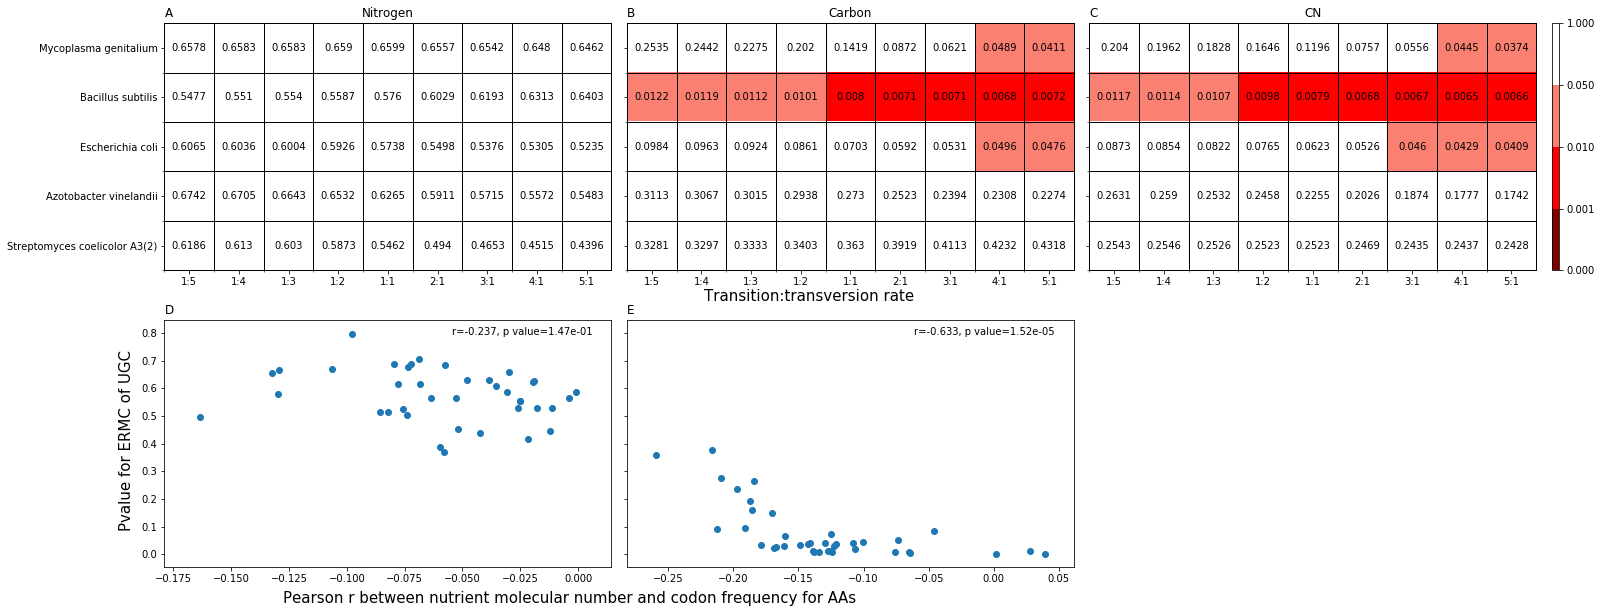

In [354]:
new_path=Path_ab2+'Figure'
pname=new_path+'/Figure1.png'

Nutrient_list=[2,0,3]
Nutrient_name_list=['Nitrogen','Carbon','CN']

gs = gridspec.GridSpec(2, 61) 
#y axis label
x_label=['1:5','1:4','1:3','1:2','1:1','2:1','3:1','4:1','5:1']
#the width ratio of subplot

fig1 = plt.figure(figsize=(25,10))
#Here I generate sub figure object and assign to corresponding location
ax1=fig1.add_subplot(gs[0, :20])   
ax1.set_title('A',loc='left')
ax2=fig1.add_subplot(gs[0, 20:40],sharey = ax1)  
ax2.set_title('B',loc='left')
ax3=fig1.add_subplot(gs[0, 40:60],sharey = ax2)  
ax3.set_title('C',loc='left')

#specify the color and value scale
cmap = colors.ListedColormap(['maroon','red','salmon','white'])
bounds=[1e-7, 1e-3, 1e-2, 0.05,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

for y,x,z in zip(Nutrient_list,[ax1,ax2,ax3],Nutrient_name_list):
    temp_data=extract_one_measurement('Bacteria',Total_pvalue_dic,y)[:,1:]
    im=x.imshow(temp_data,cmap=cmap, norm=norm,aspect='auto')
    x.set_yticks(np.arange(len(Total_pvalue_dic['Bacteria'].keys())))
    x.set_xticks(np.arange(len(x_label)))
    x.set_yticklabels(Total_pvalue_dic['Bacteria'].keys())
    x.set_xticklabels(x_label)
    #set x/y minor tick
    x.set_yticks(np.arange(len(Total_pvalue_dic['Bacteria'].keys()))+0.5, minor=True)
    x.set_xticks(np.arange(len(x_label))-0.5,minor=True)
    x.grid(which='minor', color='black', linestyle='-', linewidth=1)
    
    #here I specify the border line width
    for axis in ['top','bottom','left','right']:
        x.spines[axis].set_linewidth(1)
    
    for i in range(len(Total_pvalue_dic['Bacteria'].keys())):
        for j in range(len(x_label)):
            text = x.text(j, i,temp_data[i, j], rotation=0,
                           ha="center", va="center", color="black") 
    x.set_title(z)
    plt.setp(x.get_xticklabels(), rotation=0, ha="center",
         rotation_mode="anchor")

#This is axis is just for plotting the colorbar
ax6=fig1.add_subplot(gs[0, 60:])   
plt.colorbar(im,cax=ax6)

ax4=fig1.add_subplot(gs[1, :20])  
ax4.set_title('D',loc='left')
ax5=fig1.add_subplot(gs[1, 20:40],sharey = ax4)   
ax5.set_title('E',loc='left')

ax4.scatter(x=np.transpose(total_pearson_coef)[2],y=np.transpose(total_pvalue)[2])
ax4.text(0.8,0.95,tt3,horizontalalignment='center', verticalalignment='center', transform=ax4.transAxes)

ax5.scatter(x=np.transpose(total_pearson_coef)[0],y=np.transpose(total_pvalue)[0])
ax5.text(0.8,0.95,tt1,horizontalalignment='center', verticalalignment='center', transform=ax5.transAxes)


#hide shared y label
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)
plt.setp(ax5.get_yticklabels(), visible=False)

fig1.text(0.425, 0.5, 'Transition:transversion rate', va='center', fontsize=15)

fig1.text(0.35, 0.075, 'Pearson r between nutrient molecular number and codon frequency for AAs', ha='center',fontsize=15)
fig1.text(0.1, 0.3, 'Pvalue for ERMC of UGC', va='center', rotation='vertical',fontsize=15)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=2, hspace=None)
# plt.savefig(pname)

#### **1.2.1 Figure S1 nitrogen**

In [349]:
np.arange(len(Total_pvalue_dic[y].keys()))


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [348]:
np.arange(len(Total_pvalue_dic[y].keys()))-0.5

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
       10.5, 11.5, 12.5, 13.5])

In [347]:
np.arange(len(y_label))

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

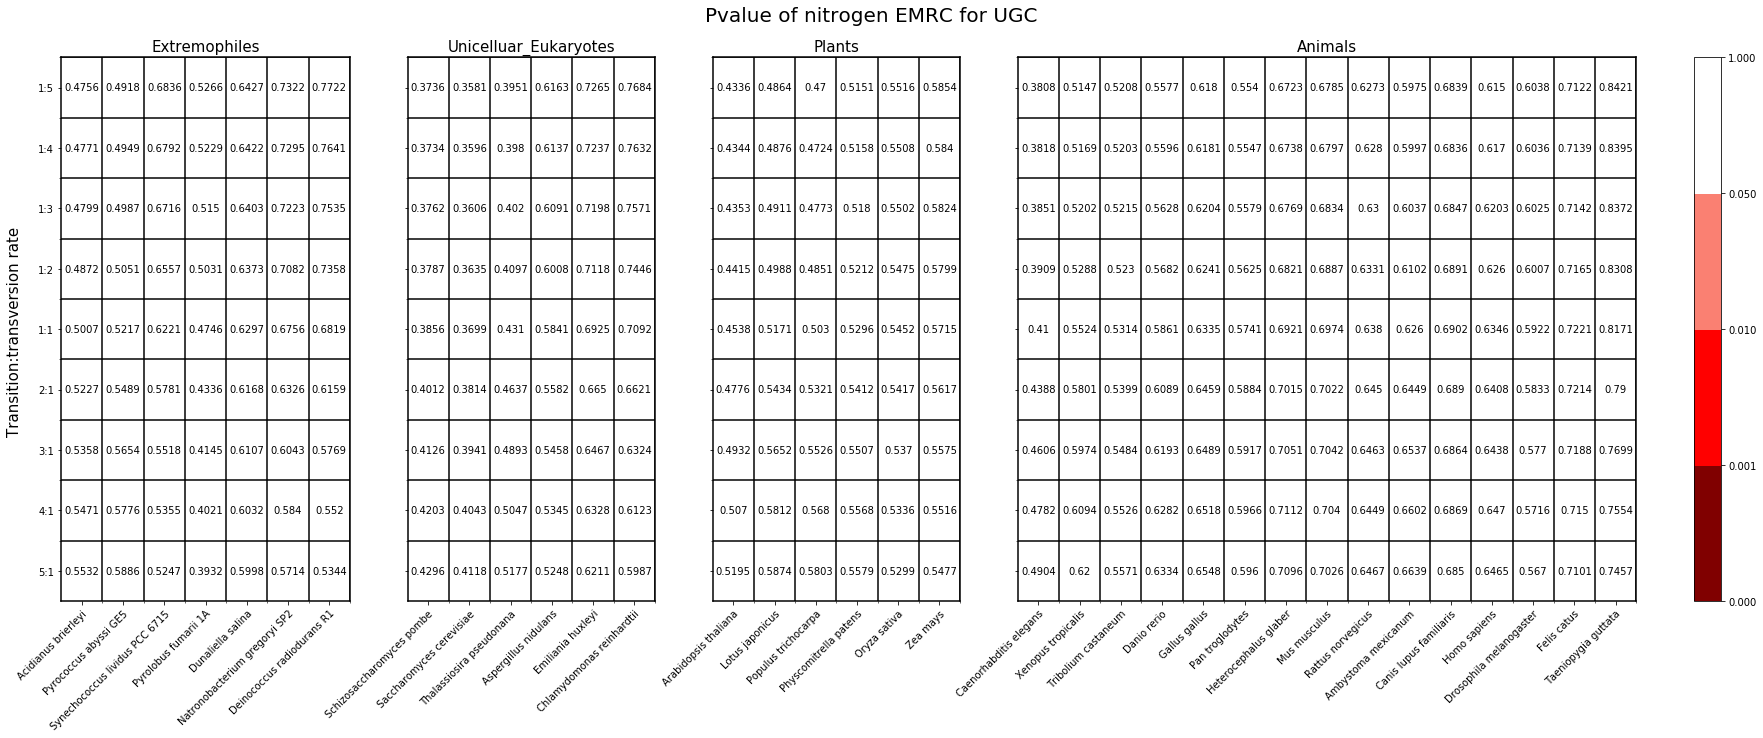

In [352]:
new_path=Path_ab2+'Figure'
pname=new_path+'/FigureS1.png'

#y axis label
y_label=['1:5','1:4','1:3','1:2','1:1','2:1','3:1','4:1','5:1']
#the width ratio of subplot
#I exclude bacteria
width_ratio=[len(Total_pvalue_dic[x].keys()) for x in Group_name_list[1:]]
#I add one axis for the colorbar
width_ratio.append(1)
fig1,axes = plt.subplots(1, 5, gridspec_kw={'width_ratios': width_ratio},figsize=(30,10),sharey=True)

#The following part is for specifying the color and scale
cmap = colors.ListedColormap(['maroon','red','salmon','white'])
bounds=[1e-7, 1e-3, 1e-2, 0.05,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

for x,y in zip(axes[:4],Group_name_list[1:]):
    temp_data=np.transpose(extract_one_measurement(y,Total_pvalue_dic,2)[:,1:])
    im=x.imshow(temp_data,cmap=cmap, norm=norm,aspect='auto')
    #set x/y major tick
    x.set_yticks(np.arange(len(y_label)))
    x.set_xticks(np.arange(len(Total_pvalue_dic[y].keys())))

    #set x/y minor tick
    x.set_xticks(np.arange(len(Total_pvalue_dic[y].keys()))+0.5, minor=True)
    x.set_yticks(np.arange(len(y_label))-0.5,minor=True)
    x.grid(which='minor', color='black', linestyle='-', linewidth=1)
    
    #here I specify the border line width
    for axis in ['top','bottom','left','right']:
        x.spines[axis].set_linewidth(1)
        
    x.set_yticklabels(y_label)
    x.set_xticklabels(Total_pvalue_dic[y].keys())
    
    
    #this is for anotation of the heatmap
    for i in range(len(y_label)):
        for j in range(len(Total_pvalue_dic[y].keys())):
            text = x.text(j, i,temp_data[i, j],
                           ha="center", va="center", color="black")
    x.set_title(y,loc='center',fontsize=15)
    plt.setp(x.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
#pay close attension here I am using ax=axes[4] but not cax=axes[4]
axes[4].axis('off')    
fig1.colorbar(im,ax=axes[4],fraction=1)

fig1.text(0.1, 0.5, 'Transition:transversion rate', va='center', rotation='vertical',fontsize=15)
fig1.text(0.5, 0.93, 'Pvalue of nitrogen EMRC for UGC', ha='center',fontsize=20)

# plt.savefig(pname)

#### **1.2.1 Figure S2 carbon**

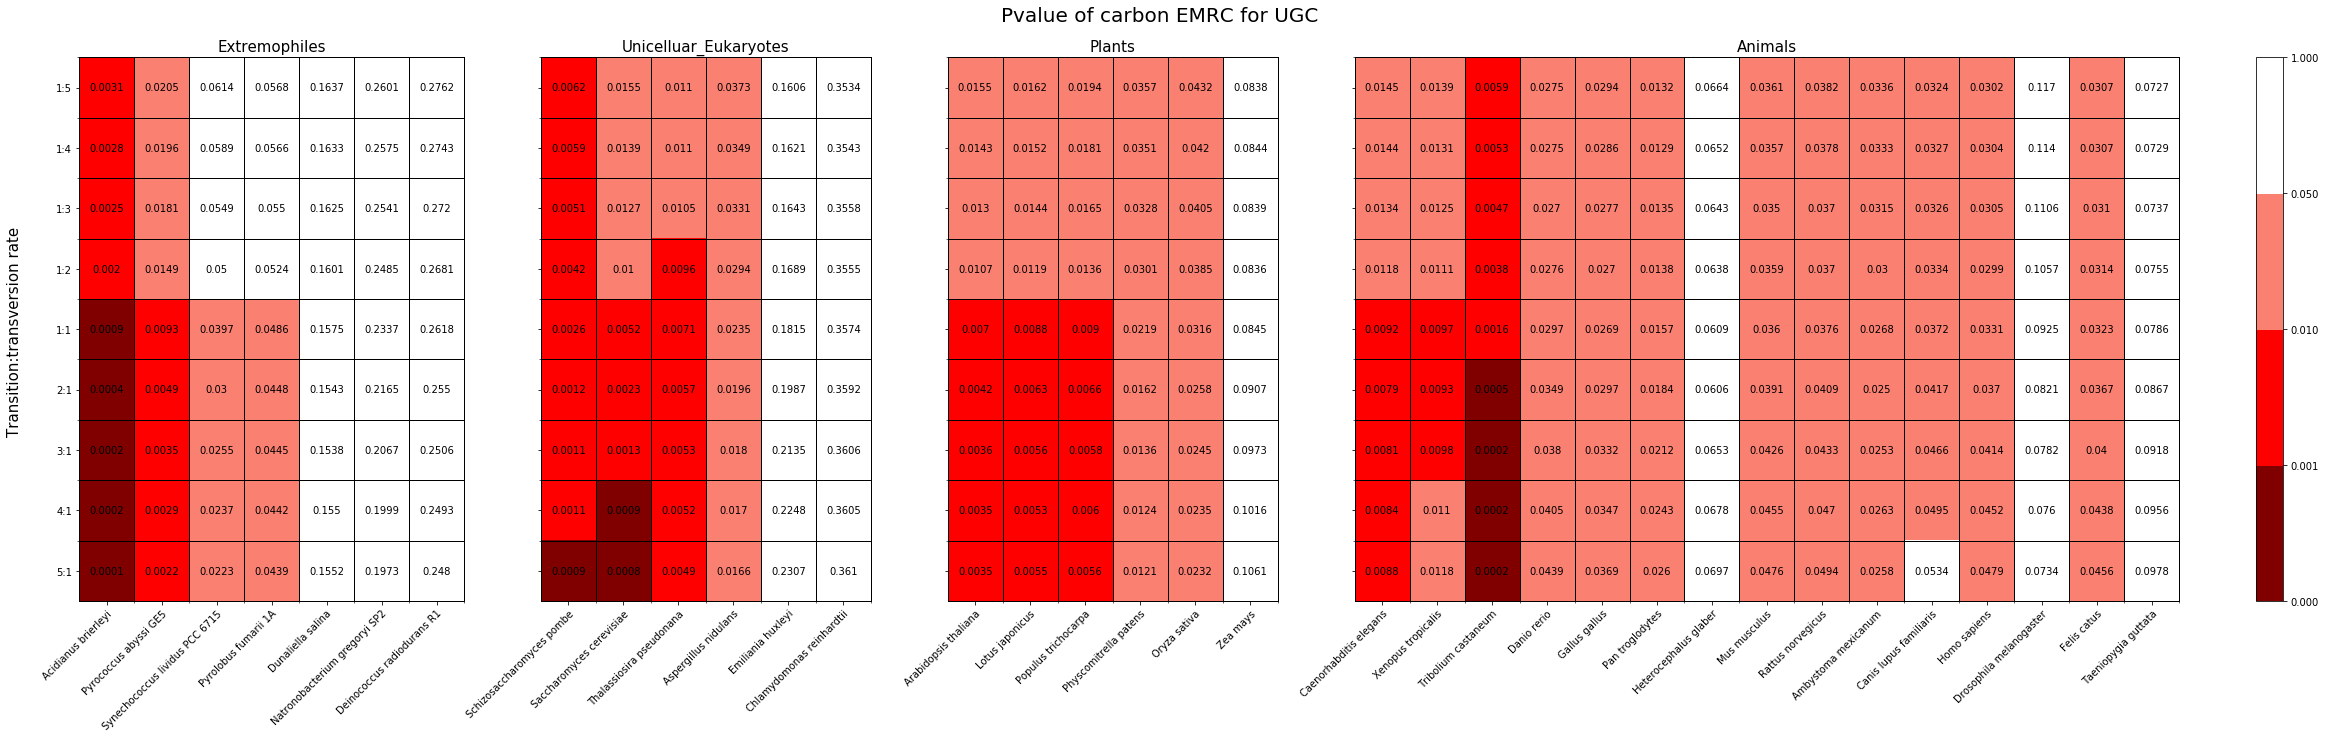

In [355]:
new_path=Path_ab2+'Figure'
pname=new_path+'/FigureS2.png'

#y axis label
y_label=['1:5','1:4','1:3','1:2','1:1','2:1','3:1','4:1','5:1']
#the width ratio of subplot
#I exclude bacteria
width_ratio=[len(Total_pvalue_dic[x].keys()) for x in Group_name_list[1:]]
#I add one axis for the colorbar
width_ratio.append(1)
fig1,axes = plt.subplots(1, 5, gridspec_kw={'width_ratios': width_ratio},figsize=(40,10),sharey=True)

#The following part is for specifying the color and scale
cmap = colors.ListedColormap(['maroon','red','salmon','white'])
bounds=[1e-7, 1e-3, 1e-2, 0.05,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

for x,y in zip(axes[:4],Group_name_list[1:]):
    temp_data=np.transpose(extract_one_measurement(y,Total_pvalue_dic,0)[:,1:])
    im=x.imshow(temp_data,cmap=cmap, norm=norm,aspect='auto')
    #set x/y major tick
    x.set_yticks(np.arange(len(y_label)))
    x.set_xticks(np.arange(len(Total_pvalue_dic[y].keys())))

    #set x/y minor tick
    x.set_xticks(np.arange(len(Total_pvalue_dic[y].keys()))+0.5, minor=True)
    x.set_yticks(np.arange(len(y_label))-0.5,minor=True)
    x.grid(which='minor', color='black', linestyle='-', linewidth=1)
    
    #here I specify the border line width
    for axis in ['top','bottom','left','right']:
        x.spines[axis].set_linewidth(1)
        
    x.set_yticklabels(y_label)
    x.set_xticklabels(Total_pvalue_dic[y].keys())
    
    
    
    #this is for anotation of the heatmap
    for i in range(len(y_label)):
        for j in range(len(Total_pvalue_dic[y].keys())):
            text = x.text(j, i,temp_data[i, j],
                           ha="center", va="center", color="black")
    x.set_title(y,loc='center',fontsize=15)
    plt.setp(x.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
#pay close attension here I am using ax=axes[4] but not cax=axes[4]
axes[4].axis('off')    
fig1.colorbar(im,ax=axes[4],fraction=1)

fig1.text(0.1, 0.5, 'Transition:transversion rate', va='center', rotation='vertical',fontsize=15)
fig1.text(0.5, 0.93, 'Pvalue of carbon EMRC for UGC', ha='center',fontsize=20)

plt.savefig(pname)

#### **1.2.1 Figure S3 carbon**

Text(0.5, 0.93, 'Pvalue of carbon and nitrogen combined EMRC for UGC')

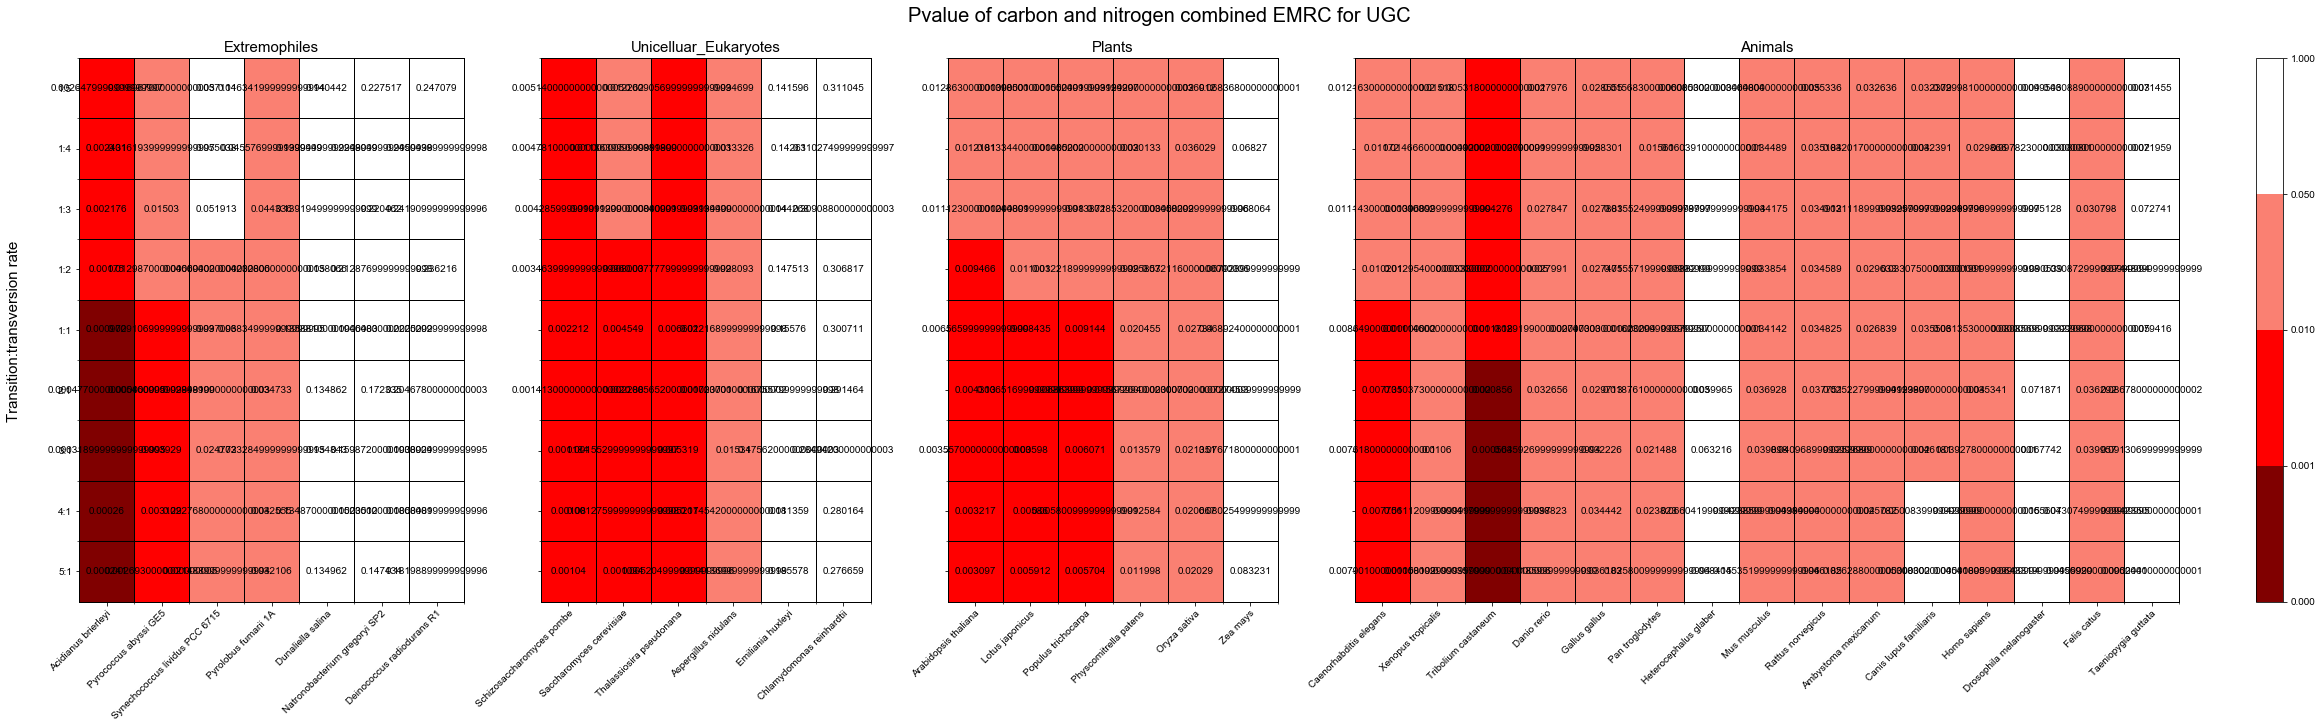

In [59]:
new_path=Path_ab2+'Figure'
pname=new_path+'/FigureS3.png'

#y axis label
y_label=['1:5','1:4','1:3','1:2','1:1','2:1','3:1','4:1','5:1']
#the width ratio of subplot
#I exclude bacteria
width_ratio=[len(Total_pvalue_dic_NC[x].keys()) for x in Group_name_list[1:]]
#I add one axis for the colorbar
width_ratio.append(1)
fig1,axes = plt.subplots(1, 5, gridspec_kw={'width_ratios': width_ratio},figsize=(40,10),sharey=True)

#The following part is for specifying the color and scale
cmap = colors.ListedColormap(['maroon','red','salmon','white'])
bounds=[1e-7, 1e-3, 1e-2, 0.05,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

for x,y in zip(axes[:4],Group_name_list[1:]):
    temp_data=np.transpose(extract_one_measurement(y,Total_pvalue_dic_NC,3)[:,1:])
    im=x.imshow(temp_data,cmap=cmap, norm=norm,aspect='auto')
    #set x/y major tick
    x.set_yticks(np.arange(len(y_label)))
    x.set_xticks(np.arange(len(Total_pvalue_dic_NC[y].keys())))

    #set x/y minor tick
    x.set_xticks(np.arange(len(Total_pvalue_dic_NC[y].keys()))+0.5, minor=True)
    x.set_yticks(np.arange(len(y_label))-0.5,minor=True)
    x.grid(which='minor', color='black', linestyle='-', linewidth=1)
    
    #here I specify the border line width
    for axis in ['top','bottom','left','right']:
        x.spines[axis].set_linewidth(1)
        
    x.set_yticklabels(y_label)
    x.set_xticklabels(Total_pvalue_dic_NC[y].keys())
    
    
    #this is for anotation of the heatmap
    for i in range(len(y_label)):
        for j in range(len(Total_pvalue_dic_NC[y].keys())):
            text = x.text(j, i,temp_data[i, j],
                           ha="center", va="center", color="black")
    x.set_title(y,loc='center',fontsize=15)
    plt.setp(x.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
#pay close attension here I am using ax=axes[4] but not cax=axes[4]
axes[4].axis('off')    
fig1.colorbar(im,ax=axes[4],fraction=1)

fig1.text(0.1, 0.5, 'Transition:transversion rate', va='center', rotation='vertical',fontsize=15)
fig1.text(0.5, 0.93, 'Pvalue of carbon and nitrogen combined EMRC for UGC', ha='center',fontsize=20)

# plt.savefig(pname)

In [63]:
np.round(temp_data,4)

array([[0.0122, 0.0152, 0.0053, 0.028 , 0.0286, 0.0157, 0.0609, 0.0346,
        0.0353, 0.0326, 0.0324, 0.03  , 0.0995, 0.0309, 0.0715],
       [0.0117, 0.0147, 0.0049, 0.0279, 0.0283, 0.0156, 0.0604, 0.0345,
        0.0352, 0.032 , 0.0324, 0.0299, 0.0978, 0.0308, 0.072 ],
       [0.0111, 0.014 , 0.0043, 0.0278, 0.0279, 0.0155, 0.0598, 0.0342,
        0.0349, 0.0311, 0.0326, 0.0299, 0.0951, 0.0308, 0.0727],
       [0.0102, 0.013 , 0.0033, 0.028 , 0.0275, 0.0156, 0.0588, 0.0339,
        0.0346, 0.0296, 0.0331, 0.03  , 0.0905, 0.0309, 0.0745],
       [0.0086, 0.0111, 0.0018, 0.0292, 0.0275, 0.0162, 0.0579, 0.0341,
        0.0348, 0.0268, 0.0355, 0.0314, 0.0809, 0.0322, 0.0794],
       [0.0077, 0.0104, 0.0009, 0.0327, 0.0297, 0.0188, 0.06  , 0.0369,
        0.0378, 0.0252, 0.0412, 0.0353, 0.0719, 0.0363, 0.0868],
       [0.0076, 0.0106, 0.0006, 0.0359, 0.0322, 0.0215, 0.0632, 0.0399,
        0.041 , 0.0253, 0.0462, 0.0393, 0.0677, 0.04  , 0.0913],
       [0.0078, 0.0111, 0.0004, 0.0388, 0

In [ ]:
#### **oxygen**